In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [19]:
import idx2numpy
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize']= [20,6]

In [3]:
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate, cross_val_score, KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,precision_score,accuracy_score,classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.pipeline import Pipeline

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten

In [5]:
import mlflow
import mlflow.sklearn
import mlflow.keras
import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)

In [6]:
# Training/Validation and Testing Data
tr_image_file = 'data/train-images-idx3-ubyte'
tr_label_file = 'data/train-labels-idx1-ubyte'
ts_image_file = 'data/t10k-images-idx3-ubyte'
ts_label_file = 'data/t10k-labels-idx1-ubyte'

tr_images = idx2numpy.convert_from_file(tr_image_file)
tr_labels = idx2numpy.convert_from_file(tr_label_file)
ts_images = idx2numpy.convert_from_file(ts_image_file)
ts_labels = idx2numpy.convert_from_file(ts_label_file)

tr_images.shape, tr_labels.shape, ts_images.shape, ts_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

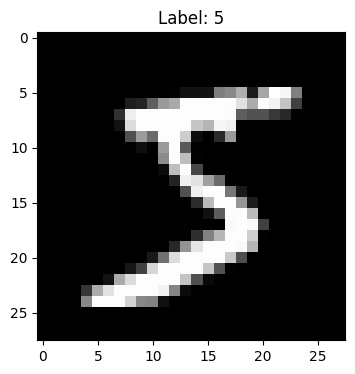

In [7]:
plt.rcParams['figure.figsize']= [10,4]

plt.imshow(tr_images[0], cmap='gray')
plt.title(f'Label: {tr_labels[0]}')
plt.show()

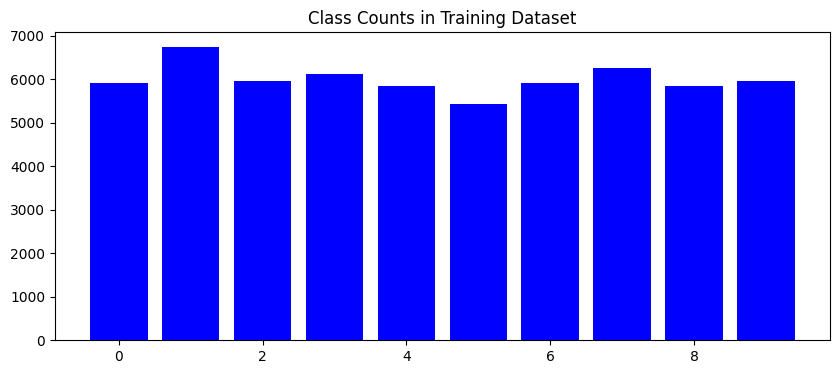

In [8]:
#Checking Class Imbalance
class_counts = Counter(tr_labels).most_common()
x = [i[0] for i in class_counts]
y = [i[1] for i in class_counts]
plt.bar(x,y,color='b')
plt.title('Class Counts in Training Dataset');

In [9]:
#Flatten Data
tr_images = tr_images.reshape(-1, 784)
ts_images = ts_images.reshape(-1, 784)

tr_images.shape, ts_images.shape

((60000, 784), (10000, 784))

In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(tr_images,tr_labels,test_size=0.1)

X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((54000, 784), (54000,), (6000, 784), (6000,))

In [11]:
#Standardize Data - Training/Validation
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

In [13]:
#Standardize Data - Testing
scaler = StandardScaler()
tr_images_scaled = scaler.fit_transform(tr_images)
ts_images_scaled = scaler.transform(ts_images)

In [12]:
def build_model(num_nodes, drop_out):
    
    model = Sequential()
    model.add(Dense(num_nodes, input_shape = (784,), kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_out,seed =0))
    model.add(Dense(10,activation='softmax'))

    sgd = tf.keras.optimizers.experimental.SGD(
        learning_rate=0.01,
        momentum=0.0)
    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
# # Define the input signature
# input_signature = tf.TensorSpec(shape=(None, 784), dtype=tf.float32)
# @tf.function(input_signature=[input_signature])
# def predict(x):
#     return {'predictions': model(x)}
# tf.saved_model.save(model, "my_model", signatures={'serving_default': predict})

# Set the MLflow server tracking uri 
# mlflow.set_tracking_uri("http://localhost:5000")


def Log_training_validation_expts(num_nodes, drop_out,training_accuracy,validation_accuracy):
    
    with mlflow.start_run() as run:
        # Log parameters
        mlflow.log_param("num_nodes", num_nodes)
        mlflow.log_param("dropout", drop_out)

        # Log metrics
        mlflow.log_metric("training_accuracy", training_accuracy)
        mlflow.log_metric("validation_accuracy", validation_accuracy)
        
        return 1

In [21]:
params = {'number_of_nodes': [32,64,128,256,512],
         'drop_out': [0.0,0.1,0.2]}

In [22]:
mlflow.set_experiment("minst-mlp-dev")
for n in tqdm(params['number_of_nodes']):
    for d in params['drop_out']:
        temp_model = build_model(n,d)
        history = temp_model.fit(X_tr_scaled, y_tr, validation_data=(X_val_scaled, y_val),
                  batch_size = 32, epochs=15, verbose=False)
        training_accuracy = history.history['accuracy'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]
        Log_training_validation_expts(n, d,training_accuracy,validation_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:48<00:00, 105.78s/it]


In [24]:
# mlflow.get_tracking_uri()

 - ### Log Final Performance with Optimal Params

In [37]:
#From looking at the Mlflow logs, it appears after num_nodes=128 and Dropout=0.1, 
# there wasn't significant improvement to justify incresing the number of nodes
model = Sequential()
model.add(Dense(128, input_shape = (784,), kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(0.1,seed =10))
model.add(Dense(10,activation='softmax'))

sgd = tf.keras.optimizers.experimental.SGD(
    learning_rate=0.01,
    momentum=0.0)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 128)               100480    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
history = model.fit(X_tr_scaled, y_tr, validation_data=(X_val_scaled, y_val),
                  batch_size = 32, epochs=15, verbose=False)

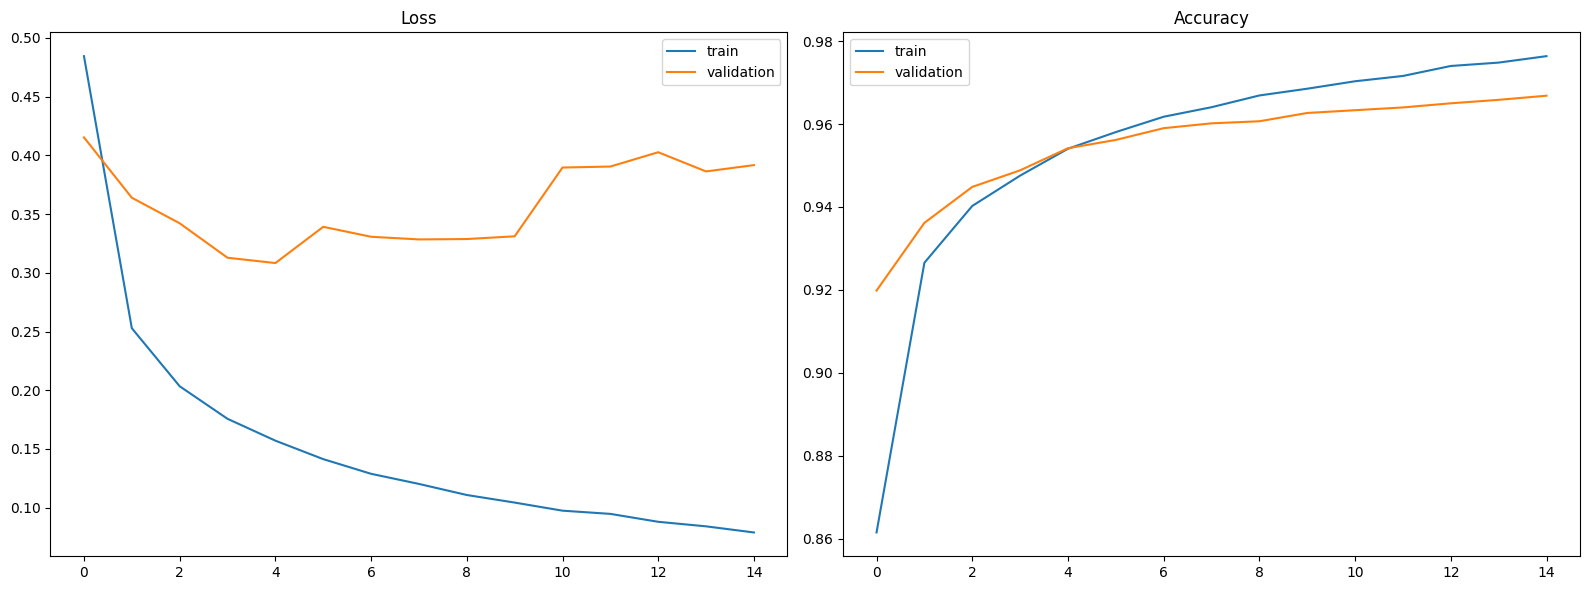

In [39]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_title('Loss')
# axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.tight_layout();

In [40]:
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

In [41]:
test_loss, test_accuracy = model.evaluate(ts_images_scaled, ts_labels)
test_loss, test_accuracy

313/313 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.9673


(0.12900672852993011, 0.9672999978065491)

In [43]:
mlflow.set_experiment("minst-mlp-dev")
with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_param("num_nodes", 128)
    mlflow.log_param("dropout", 0.0)

    # Log metrics
    mlflow.log_metric("training_accuracy", training_accuracy)
    mlflow.log_metric("validation_accuracy", validation_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)